# Build a Retrieval Augmented Generation (RAG) App

LLM 支持的最强大的应用程序之一是复杂的问答 （Q&A） 聊天机器人。这些应用程序可以回答有关特定源信息的问题。这些应用程序使用一种称为检索增强生成 （RAG） 的技术。

本教程将演示如何构建简单的 Q&A 应用程序 在文本数据源上。在此过程中，我们将回顾一个典型的问答 体系结构，并突出显示用于更高级 Q&A 技术的其他资源。我们还将看到 LangSmith 如何帮助我们跟踪和理解我们的应用程序。 随着我们的应用程序的发展，LangSmith 将变得越来越有用 复杂性。

如果您已经熟悉基本检索，您可能还对以下内容感兴趣 这是对[不同检索技术的高级概述](https://python.langchain.com/v0.2/docs/concepts/#retrieval)。

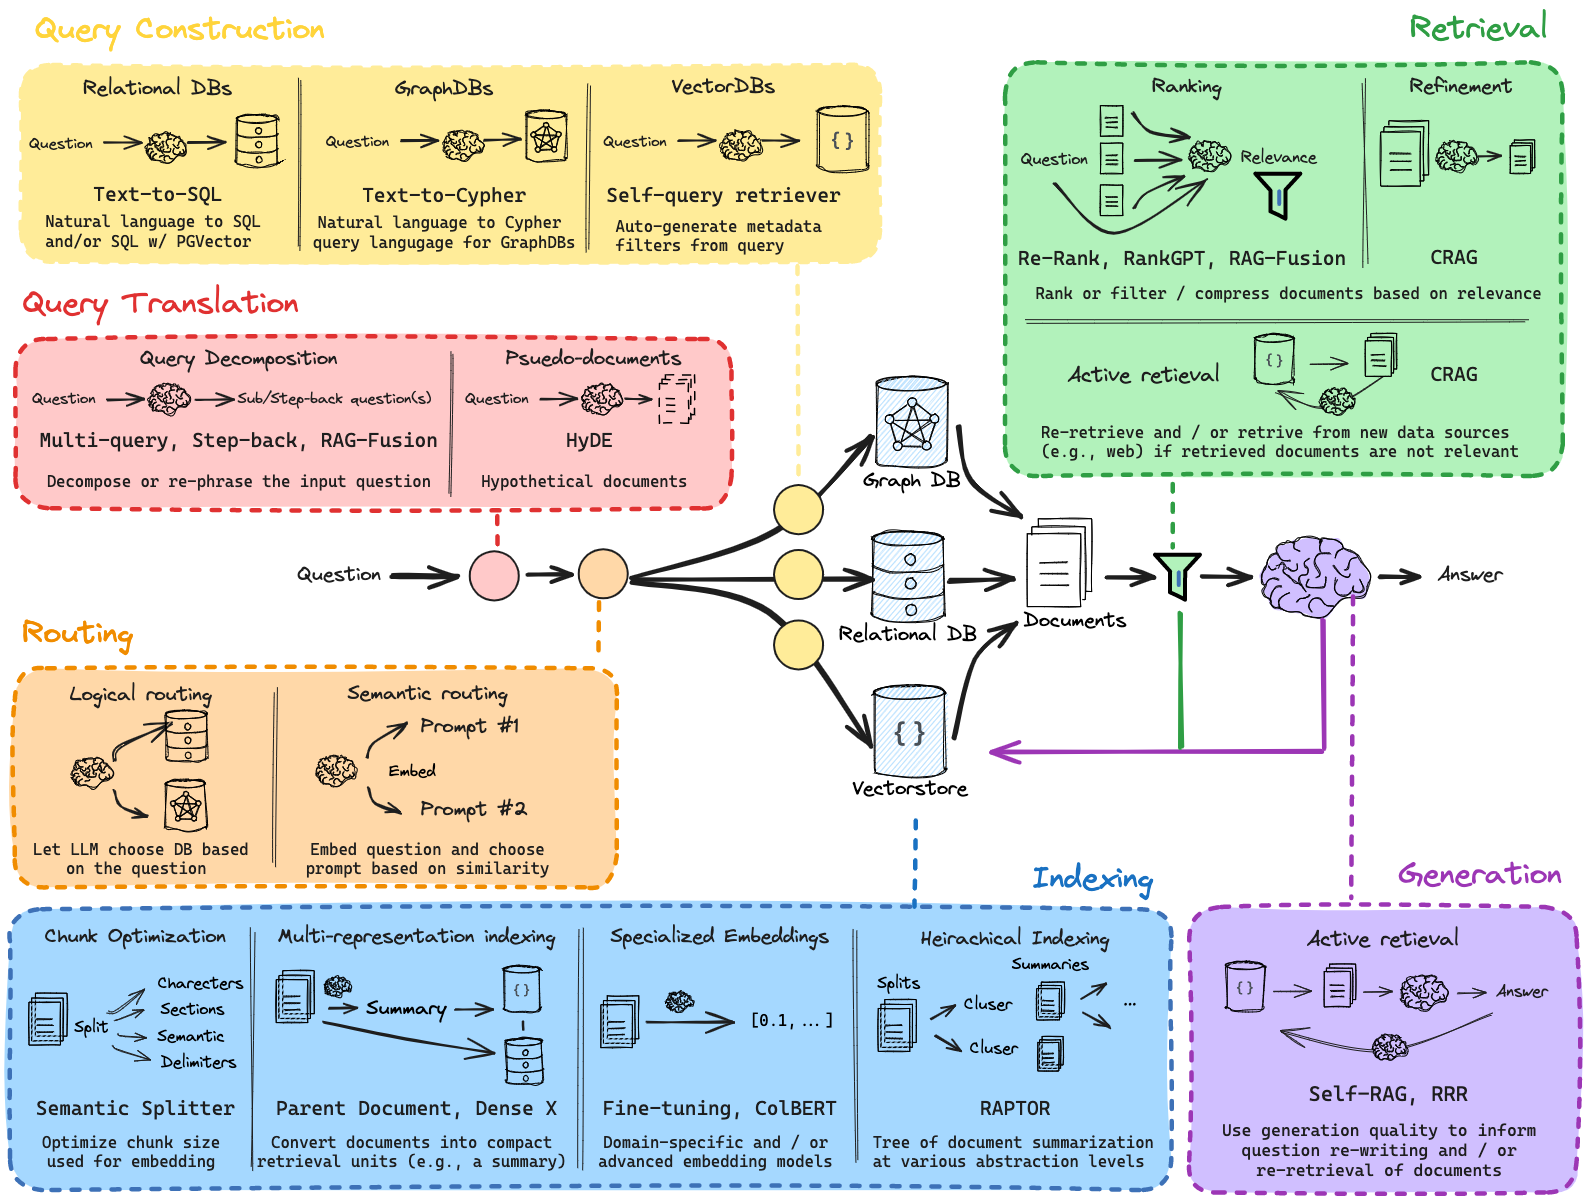



RAG 是一种使用额外数据增强 LLM 知识的技术。

LLM 可以对广泛的主题进行推理，但他们的知识仅限于他们接受培训的特定时间点之前的公共数据。如果要构建可以推理私有数据或模型截止日期后引入的数据的 AI 应用程序，则需要使用模型所需的特定信息来增强模型的知识。引入适当信息并将其插入模型提示符的过程称为检索增强生成 （RAG）。

LangChain有许多组件，旨在帮助构建Q&A应用程序，以及更普遍的RAG应用程序。

注意：这里我们重点介绍非结构化数据的问答。如果您对基于结构化数据的 RAG 感兴趣，请查看我们关于对 SQL 数据进行问答的教程。

# Concepts

典型的 RAG 应用程序有两个主要组件：

**Indexing**：用于从源引入数据并对其进行索引的管道。这通常发生在离线状态。

**Retrieval and generation**：实际的 RAG 链，它在运行时接受用户查询并从索引中检索相关数据，然后将其传递给模型。

从原始数据到答案最常见的完整序列如下所示：

- Indexing

1. Load：首先我们需要加载数据。这是通过文档加载器完成的。
2. Split：文本拆分器将大块拆分为更小的块。这对于索引数据和将数据传递到模型都很有用，因为大块更难搜索，并且不适合模型的有限上下文窗口。Documents
3. Store：我们需要某个地方来存储和索引我们的拆分，以便以后可以搜索它们。这通常是使用 VectorStore 和 Embeddings 模型完成的。

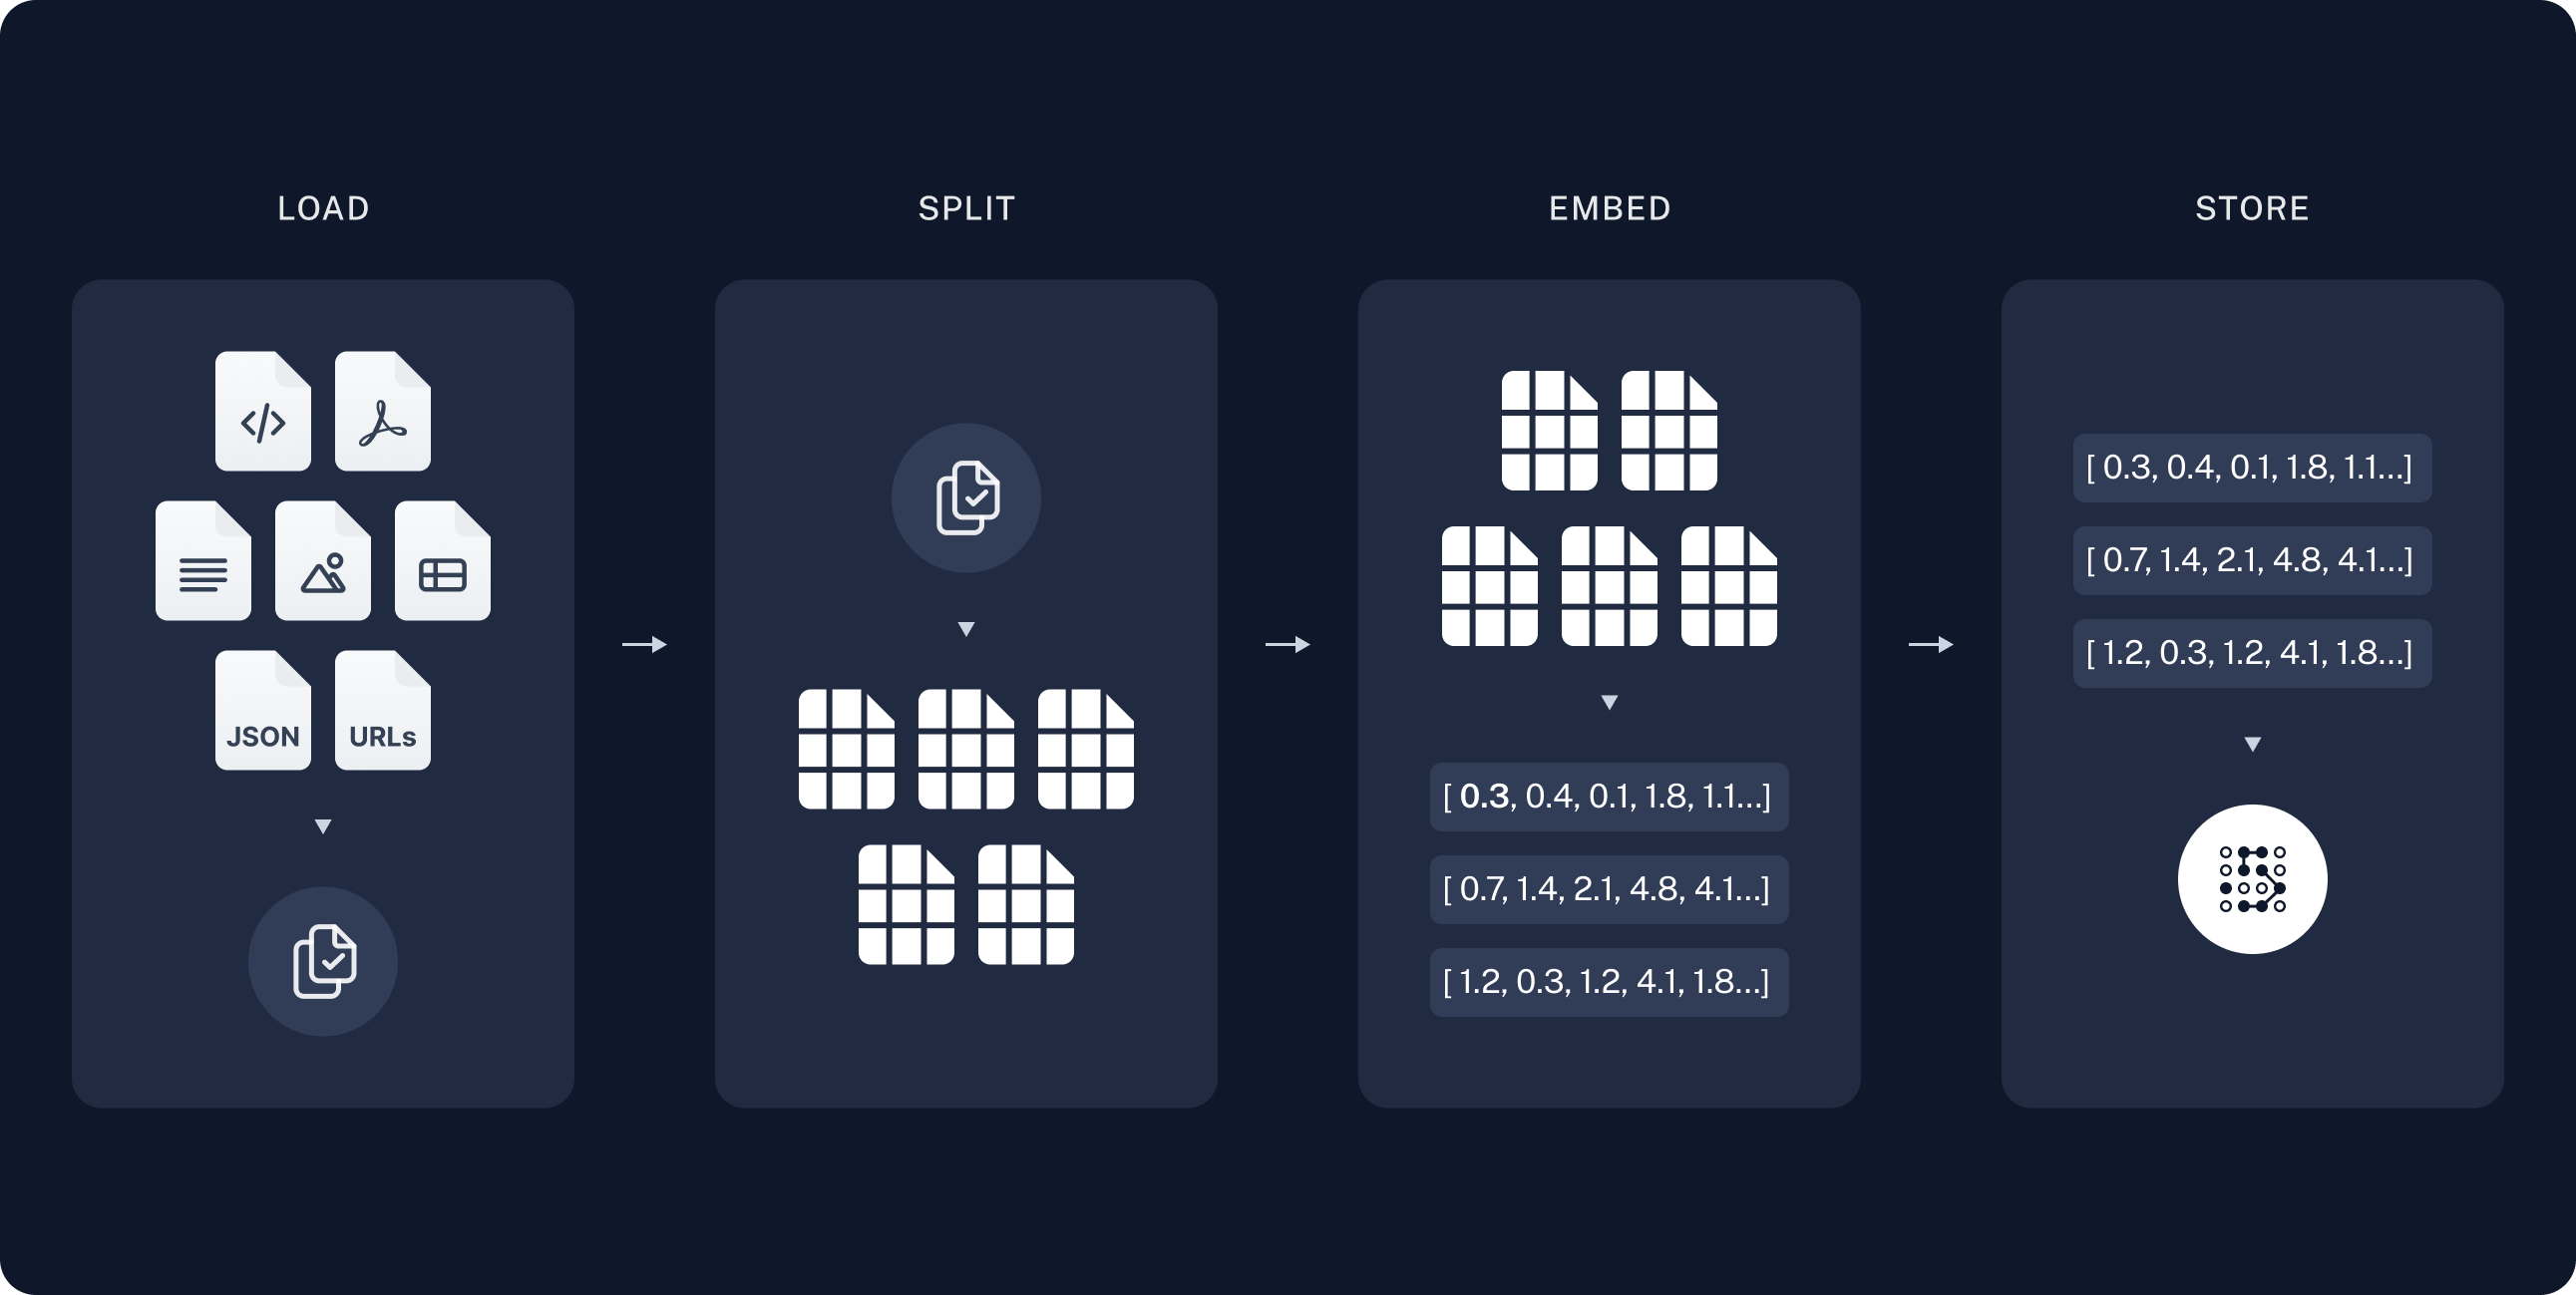

- Retrieval and generation

4. Retrieve: 给定用户输入，使用 Retriever 从存储中检索相关拆分。
5. Generate: ChatModel / LLM 使用包含问题和检索数据的提示生成答案

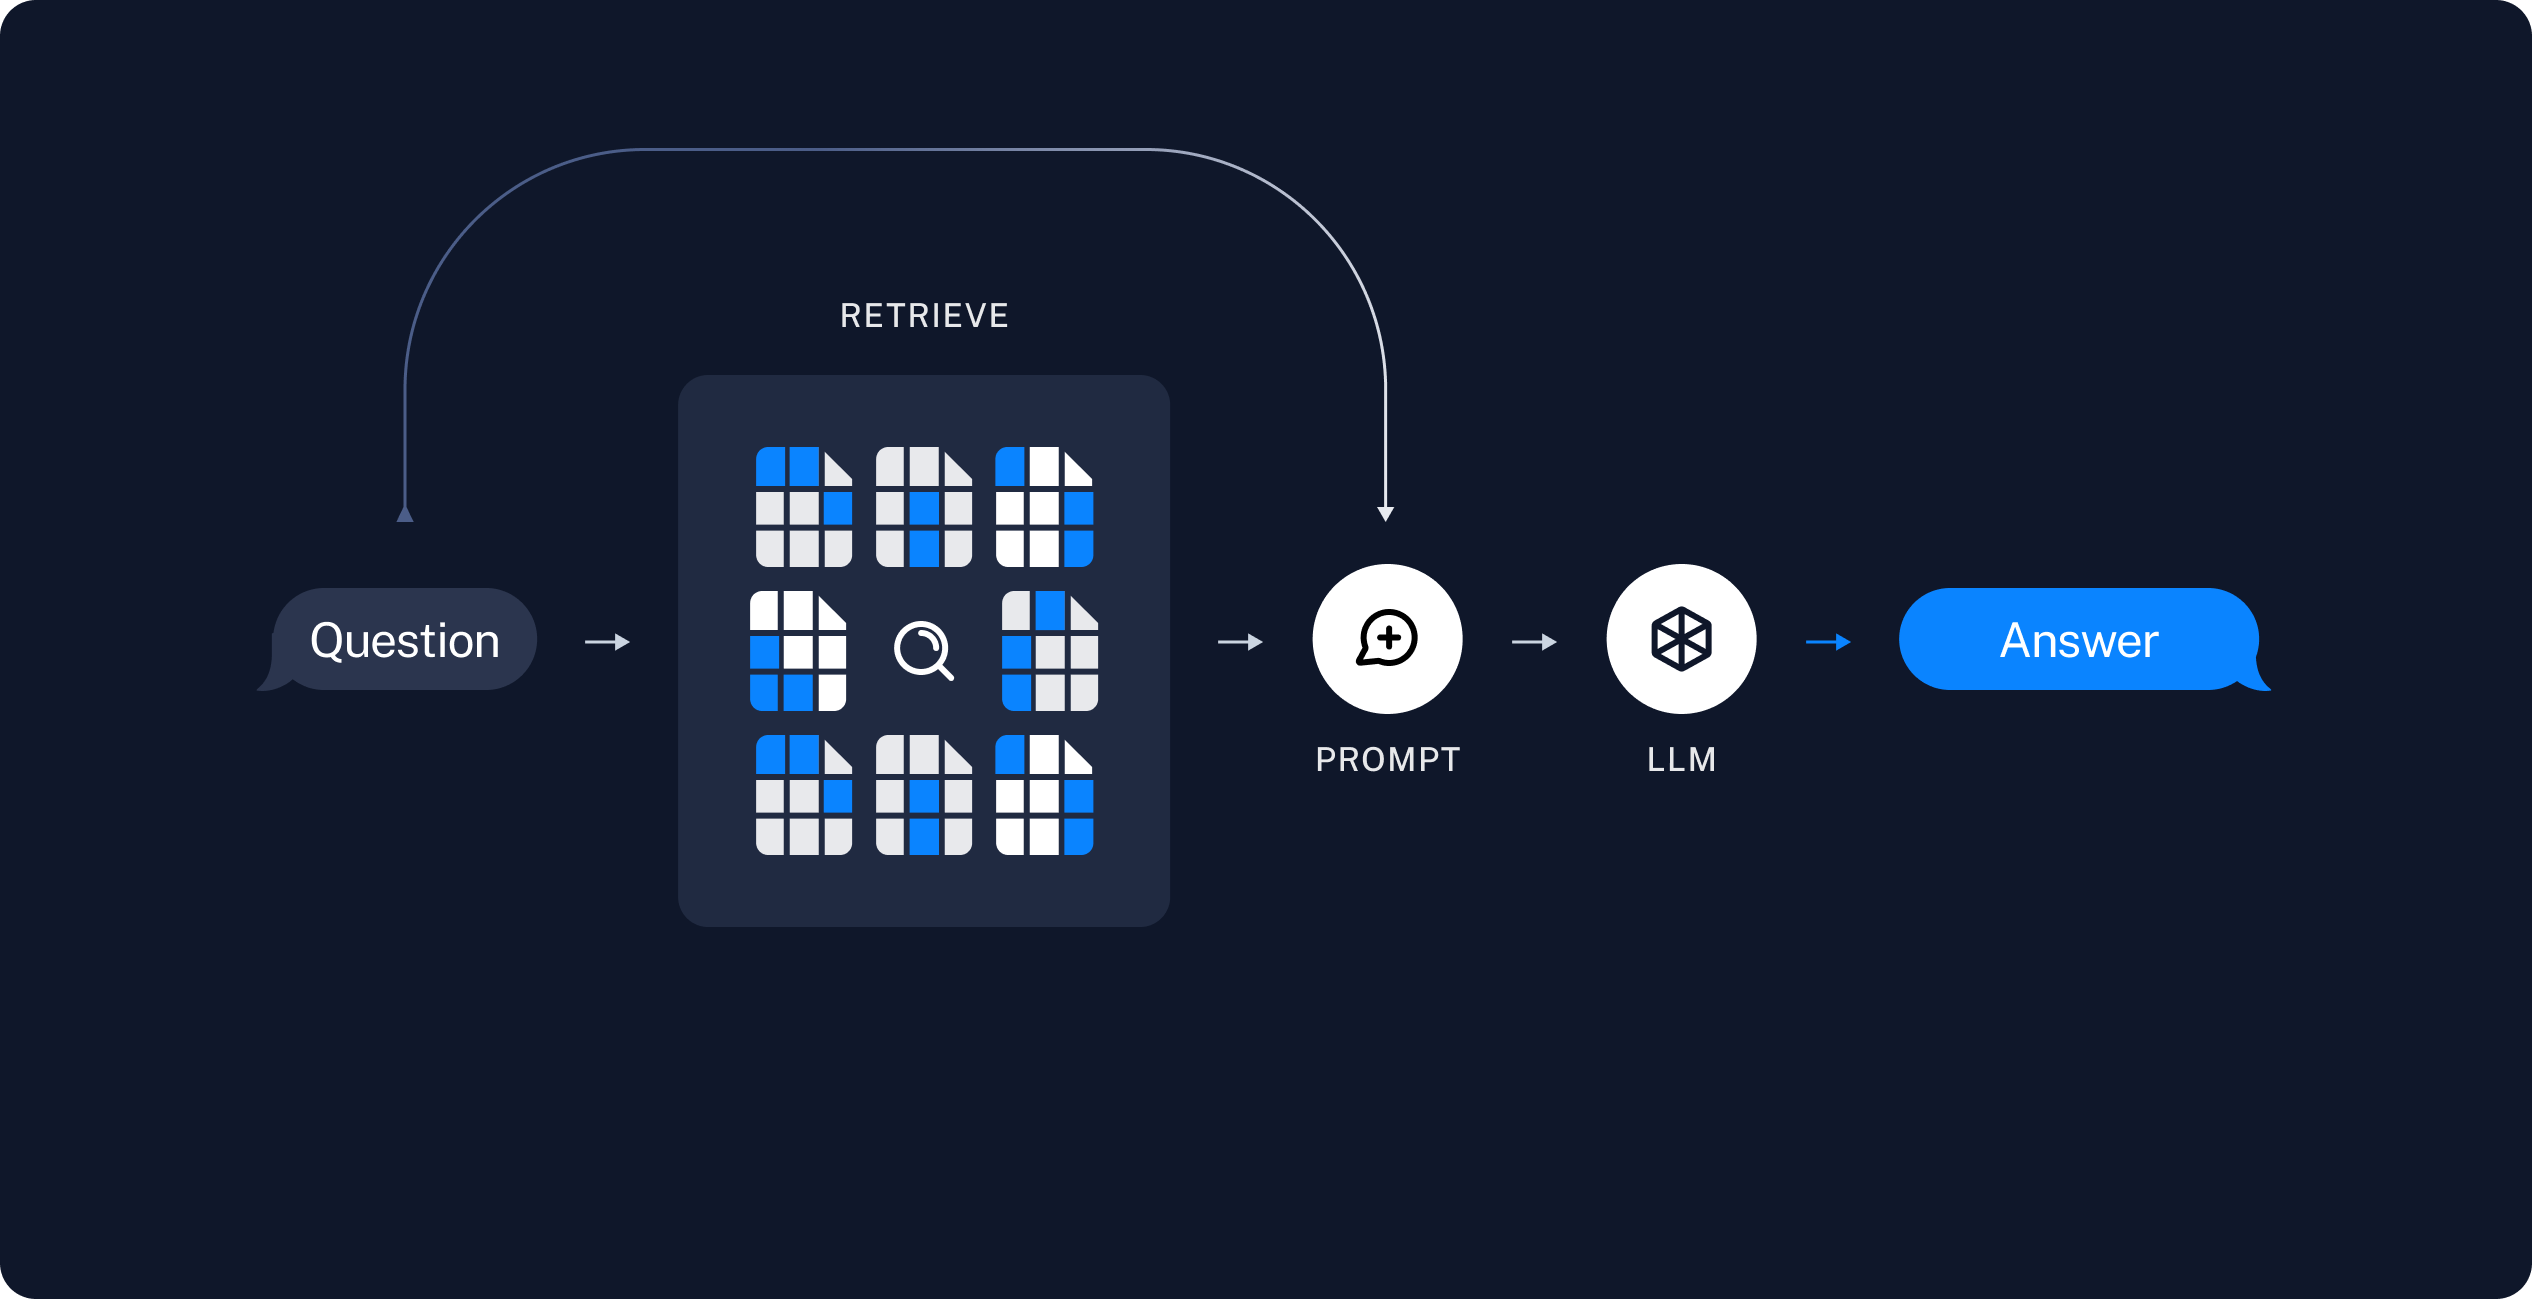

# Preview

在本指南中，我们将构建一个应用程序，该应用程序可以回答关于某个网站内容的问题。我们将使用的具体网站是 Lilian Weng 撰写的《LLM Powered Autonomous Agents》博客文章，这使我们能够针对文章内容提出问题。我们可以创建一个简单的索引管道和检索增强生成（RAG）链，代码量大约在20行左右：

In [1]:
import os
from langchain_openai import ChatOpenAI
API_SECRET_KEY = ""
BASE_URL = ""  # 代理 base-url 记得加上 /v1

os.environ["OPENAI_API_KEY"] = API_SECRET_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL

model = ChatOpenAI(temperature=0.9)

In [2]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS


# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

EMBEDDING_DEVICE = "cuda"
embeddings = HuggingFaceEmbeddings(model_name="..\models\m3e-base",
                                   model_kwargs={'device': EMBEDDING_DEVICE})

# 生成 分词|切分器
text_splitter = RecursiveCharacterTextSplitter()
# 对 load 进来的文档(s) 进行分词&切分
documents = text_splitter.split_documents(documents=docs)

# 建立索引：将词向量存储向量数据库
vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings)


# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever , "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

USER_AGENT environment variable not set, consider setting it to identify your requests.
d:\Program\Anaconda3\envs\langchain-env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
d:\Program\Anaconda3\envs\langchain-env\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


AIMessage(content='Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This can be done through methods like Chain of Thought or Tree of Thoughts, which transform big tasks into multiple manageable tasks. Task decomposition can be achieved through LLM with simple prompting, task-specific instructions, or human inputs.', response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 3308, 'total_tokens': 3370}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-2a3f0ecf-f957-481c-9496-74613888f031-0', usage_metadata={'input_tokens': 3308, 'output_tokens': 62, 'total_tokens': 3370})

# 详细演练

让我们一步一步地完成上面的代码，以真正了解什么是RAG

我们需要首先加载博客文章内容。为此，我们可以使用 DocumentLoaders，它们是从源加载数据并返回 文件列表。 A 是具有 （str） 和 （dict） 的对象。Documentpage_contentmetadata

在本例中，我们将使用 WebBaseLoader， 用于从 Web URL 加载 HTML 和 将其解析为文本。我们可以通过传递来自定义 HTML -> 文本解析 在参数中通过解析器（参见 BeautifulSoup 文档）。 在这种情况下，只有带有类“post-content”、“post-title”或 “post-header”是相关的，因此我们将删除所有其他标题。`urllib` `BeautifulSoup` `BeautifulSoup` `bs_kwargs`

文档：[WebBaseLoader](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

len(docs[0].page_content)

43131

In [ ]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


# Indexing: Split

我们的加载文档长度超过42,000个字符。这个长度太长，无法适应许多模型的上下文窗口。即使是那些可以容纳完整文章的模型，也可能难以在非常长的输入中找到信息。

为了解决这个问题，我们将把文档拆分成小块进行嵌入和向量存储。这将有助于我们在运行时只检索博客文章中最相关的部分。

在这种情况下，我们将把文档拆分成每块1000个字符，并在块之间有200个字符的重叠。重叠有助于减小将一个声明与其相关的重要上下文分开的可能性。我们使用递归字符文本分割器（RecursiveCharacterTextSplitter），该分割器将使用常见的分隔符（如换行符）递归地拆分文档，直到每个块达到适当的大小。这是推荐的用于通用文本案例的文本分割器。

我们设置 add_start_index=True，以便在初始文档中每个拆分文档开始的字符索引作为元数据属性“start_index”被保留。

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # 每个块的大小为1000个字符
    chunk_overlap=200,  # 块之间有200个字符的重叠
    add_start_index=True # 在每个块的元数据中保留初始文档中每个拆分块开始的字符索引
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

66

In [ ]:
len(all_splits[0].page_content)

969

In [ ]:
all_splits[10].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 7056}

### 更深入
`TextSplitter`：将 s 列表拆分为更小的对象 块。s 的子类。`Document` `DocumentTransformer`

- 阅读[操作指南文档](https://python.langchain.com/v0.2/docs/how_to/#text-splitters)，了解有关使用不同方法拆分文本的更多信息
- [代码（py 或 js）](https://python.langchain.com/v0.2/docs/integrations/document_loaders/source_code/)
- [科学论文](https://python.langchain.com/v0.2/docs/integrations/document_loaders/grobid/)
- [接口](https://api.python.langchain.com/en/latest/base/langchain_text_splitters.base.TextSplitter.html)：基本接口的 API 参考。

`DocumentTransformer`：对列表执行转换的对象 的对象。 `Document`

- [文档](https://python.langchain.com/v0.2/docs/how_to/#text-splitters)：有关如何使用的详细文档DocumentTransformers
- [集成](https://python.langchain.com/v0.2/docs/integrations/document_transformers/)
- [接口](https://api.python.langchain.com/en/latest/documents/langchain_core.documents.transformers.BaseDocumentTransformer.html)：基本接口的 API 参考。

# Indexing: Store

现在我们需要索引我们的 66 个文本块，以便我们可以搜索它们 在运行时。执行此操作的最常见方法是嵌入 每个文档都拆分这些嵌入并将其插入到矢量数据库中 （或矢量存储）。当我们想搜索我们的拆分时，我们会采取 文本搜索查询，嵌入它，并执行某种“相似性” 搜索以识别具有与 我们的查询嵌入。最简单的相似度度量是余弦 相似性 — 我们测量每对 嵌入（高维向量）。

我们可以将所有文档拆分嵌入并存储在单个命令中 使用 Chroma 矢量存储和 OpenAIEmbeddings 模型。

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

### 更深入

`Embeddings`：文本嵌入模型的包装器，用于转换 文本到embeddings。

[文档](https://python.langchain.com/v0.2/docs/how_to/embed_text/)：有关如何使用嵌入的详细文档。

[集成](https://python.langchain.com/v0.2/docs/integrations/text_embedding/)：30+ 集成可供选择。

[接口](https://api.python.langchain.com/en/latest/embeddings/langchain_core.embeddings.Embeddings.html)：基本接口的 API 参考。

`VectorStore`：围绕向量数据库的包装器，用于存储和 查询embeddings。

[文档](https://python.langchain.com/v0.2/docs/how_to/vectorstores/)：有关如何使用向量存储的详细文档。

[集成](https://python.langchain.com/v0.2/docs/integrations/vectorstores/)：40+ 集成可供选择。

[接口](https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html)：基本接口的 API 参考。

这样就完成了管道的索引部分。在这一点上 我们有一个可查询的向量存储，其中包含我们的分块内容 博客文章。给定用户问题，理想情况下，我们应该能够返回 回答问题的博客文章片段。

# Retrieval and Generation: Retrieve

现在让我们编写实际的应用程序逻辑。我们想创建一个简单的 接受用户问题的应用程序，搜索相关文档 对于该问题，将检索到的文档和初始问题传递给 一个模型，并返回一个答案。

首先，我们需要定义搜索文档的逻辑。 LangChain 定义了一个 Retriever 接口 它包装一个索引，该索引可以返回给定字符串的相关 查询。`Documents`

最常见的类型是 VectorStoreRetriever， 它使用矢量存储的相似性搜索功能来 便于检索。任何都可以轻松转换为：`Retriever` `VectorStore` `Retriever` `VectorStore.as_retriever()`

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")

len(retrieved_docs)

print(retrieved_docs)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search

In [ ]:
print(retrieved_docs[0].page_content)

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
T

### 更深入

向量存储通常用于检索，但还有其他方法 也要进行检索。

`Retriever` ：给定文本查询返回对象`Document`

- [Docs](https://python.langchain.com/v0.2/docs/how_to/#retrievers) ：进一步 有关界面和内置检索技术的文档。 其中一些包括：
  - `MultiQueryRetriever` 生成输入的变体 提高检索命中率的问题。
  - `MultiVectorRetriever` 而是生成 嵌入， 也是为了提高检索命中率。
  - `Max marginal relevance`选择相关性和 检索到的文档之间的多样性，以避免重复传递 上下文。
  - 在矢量存储检索期间，可以使用以下方法对文档进行筛选 元数据筛选器，例如使用自查询 猎犬。

- [Integrations](https://python.langchain.com/v0.2/docs/integrations/retrievers/)：集成 提供检索服务。

- [Interface](https://api.python.langchain.com/en/latest/retrievers/langchain_core.retrievers.BaseRetriever.html)： 基本接口的 API 参考。

### Retrieval and Generation: Generate

让我们把它们放在一起，形成一个链条，接受一个问题，检索 相关文档，构造提示，将其传递给模型，然后 分析输出。

In [ ]:
import os
from langchain_openai import ChatOpenAI
API_SECRET_KEY = ""
BASE_URL = ""  # 代理 base-url 记得加上 /v1

os.environ["OPENAI_API_KEY"] = API_SECRET_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL

model = ChatOpenAI(temperature=0.9)

我们从 LangChain 提示库中获取一个提示模板：

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:")]

In [ ]:
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question 
Context: filler context 
Answer:


使用 LCEL 可运行协议来定义一个链，使得各个组件可以透明地连接在一起，并自动跟踪链的执行情况。

这个链的功能如下：

- retriever | format_docs：将问题传递给检索器，生成文档对象，然后格式化为字符串。
- RunnablePassthrough()：原样传递输入问题。
- prompt：构建格式化的提示。
- llm：运行推理。
- StrOutputParser()：从模型的输出消息中提取字符串内容。

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)


Task Decomposition is the process of breaking down a complicated task into smaller, more manageable subgoals. This can be done through various techniques such as Chain of Thought (CoT) or Tree of Thoughts (ToT). The ultimate goal of task decomposition is to shed light into an interpretation of the model's thinking process and generate manageable tasks.

LCEL 解析
1. 组件实例化

- 这些组件（如 retriever, prompt, llm 等）都是 Runnable 的实例。这意味着它们实现了相同的方法，如 sync 和 async 的 invoke、stream、batch 等，这使得它们能够轻松地连接在一起。

2. 连接组件

- 它们可以通过操作符 | 连接成一个 RunnableSequence（也是一个 Runnable）。
- LangChain 会自动将某些对象转换为 runnables，当遇到操作符 | 时。例如，这里 format_docs 被转换为 - RunnableLambda，而包含 context 和 question 的字典被转换为 RunnableParallel。

3. 输入问题的流转

- 输入到 prompt 的预期是一个包含键 context 和 question 的字典。所以这个链的第一个元素会计算出这些键的值。
- retriever | format_docs：这个部分将问题传递给 retriever，生成 Document 对象，然后传递给 format_docs 生成字符串。
- RunnablePassthrough()：这个部分不改变输入问题，原样传递。

4. 构建和调用链 

如果你构建了如下链：

In [20]:
chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
)


这样就会构建一个格式化的提示，准备进行推理。注意，在开发LCEL时，可以通过测试这种子链来验证

5. 链的最后步骤
- llm：运行推理。
- StrOutputParser()：从LLM的输出消息中提取字符串内容。


# 内置链
LangChain 提供了方便的函数来实现上述的 LCEL（LangChain Execution Language）。这里我们将组合两个函数：

1. `create_stuff_documents_chain`

这个函数指定如何将检索到的上下文内容传递到prompt和LLM中。在这个例子中，我们会将所有检索到的内容直接填充到提示中，不进行摘要或其他处理。这主要实现了我们上面的 `rag_chain`，其输入键是 `context` 和 `input`，它使用检索到的上下文和查询生成答案。

2. `create_retrieval_chain`

这个函数添加了检索步骤，并将检索到的上下文传递通过链传递，最终提供给答案。它的输入键是 `input`，输出包含 `input`、`context` 和 `answer`。

In [3]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# 定义系统提示
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

# 创建提示模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# 创建问答链
question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# 调用链来生成回答
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print(response["answer"])



{
    "thoughts": {
        "text": "Task decomposition is a process used in AI to break down complex tasks into smaller, more manageable steps.",
        "reasoning": "This allows for a systematic approach to problem solving, making tasks more feasible for AI systems.",
        "plan": "- Identifying a complex task to be solved\n- Breaking it down into smaller tasks\n- Managing and executing these smaller tasks\n",
        "criticism": "While task decomposition simplifies complex tasks, it's important to ensure that the subtasks still align with the overall goal.",
        "speak": "Task decomposition is the process of breaking down complex tasks into smaller, simpler tasks to make them more manageable for AI systems. It's like taking a big puzzle and sorting out its pieces before you start putting it together."
    },
    "command": {
        "name": "define",
        "args": {
            "term": "task decomposition"
        }
    }
}


: 

#### 输出来源文档

如何在问答应用中向用户展示生成答案所使用的来源文档。具体来说，LangChain 的内置函数 create_retrieval_chain 会将检索到的源文档通过键 context 传递到输出中。

遍历 response["context"] 中的每个文档并打印：for document in response["context"]: print(document)

In [22]:
for document in response["context"]:
    print(document)
    print()

page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or ma